In [1]:
import sys
import os

import numpy as np
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
%matplotlib inline

from gamtools import segregation, cosegregation, matrix
from gam_follow_up import config, correlations
from common import plotting

In [2]:
seg_3np_40kb_path = config.in_data_raw('multiplex-gam-data/gamtools_output/segregation_at_40kb.passed_qc.table')
seg_3np_40kb = segregation.open_segregation(seg_3np_40kb_path)

In [3]:
chroms = ['chr{}'.format(c) for c in range(1,20)]

In [4]:
def matrix_from_base_path(base_path, chrom):
    chrom_path = base_path.format(chrom)
    _windows, chrom_matrix = matrix.read_file(chrom_path)
    return chrom_matrix

def keep_diagonals(in_matrix, diag_from, diag_to=None):
    
    if diag_to is None:
        diag_to = len(in_matrix)
        
    out_matrix = np.zeros_like(in_matrix) * np.nan
    
    for d in range(diag_from, diag_to):
        indices = matrix.kth_diag_indices(out_matrix, d)
        out_matrix[indices] = in_matrix[indices]
        
    return out_matrix

In [5]:
def correlate_from_one_seg_table(seg_table, base_path, matrix_regions=[(0, None)]):

    out_correlations = [[] for i in matrix_regions]

    for chrom in chroms:
        
        print 'calculating {} ({} samples)'.format(chrom, seg_table.shape[1])
        sys.stdout.flush()
        
        chrom_matrix_1 = cosegregation.get_dprime(seg_table, chrom)

        chrom_matrix_2 = matrix_from_base_path(base_path, chrom)

        for i, (d_start, d_stop) in enumerate(matrix_regions):

            this_corr = correlations.correlate_matrices(
                keep_diagonals(chrom_matrix_1, d_start, d_stop),
                keep_diagonals(chrom_matrix_2, d_start, d_stop))

            out_correlations[i].append(this_corr)
            
    return out_correlations

In [6]:
def random_sample_df(input_df, n):
    selected_cols = np.random.choice(input_df.columns, n, replace=False)
    return input_df[selected_cols]

In [7]:
matrix_1np_base = config.in_data_processed('contact-matrices/1np/40kb/segregation_at_40kb.passed_qc.{}_dprime.txt.gz')

In [8]:
np.random.seed(64448)

corr_path = config.in_data_intermediate('correlations/saturation_1np_vs_4np_40kb.npz')

if not os.path.exists(corr_path):

    close_means = []
    
    for subsample_n in range(10,250,10):
        print('Getting segregation table subset (n={})'.format(subsample_n))
        sys.stdout.flush()
        rnd_df = random_sample_df(seg_3np_40kb, subsample_n)

        close_corr = correlate_from_one_seg_table(rnd_df, matrix_1np_base, [(0, 100)])[0]

        print subsample_n, np.mean(close_corr)
        close_means.append(close_corr)
        
    close_means = np.array(close_means)
    np.savez(corr_path, close_means)

close_means = np.load(corr_path)['arr_0']

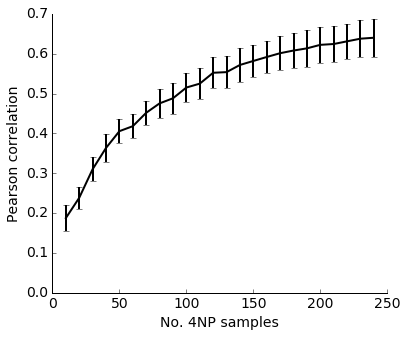

In [14]:
plt.figure(figsize=(6,5), facecolor='white')
plt.rcParams['font.size'] = 14

plt.errorbar(range(10,250,10),
             np.mean(close_means, axis=1),
             yerr=np.std(close_means, axis=1),
             color='black', lw=2)

plt.ylabel('Pearson correlation')
plt.xlabel('No. 4NP samples')
plt.ylim(0, 0.7)

plotting.simpleaxis()
plt.savefig(
    config.in_figures('fig-s3/correlation-3nps-v-1np.eps'))